<a href="https://colab.research.google.com/github/amanksharma23/Retail-sales-prediction-Supervised-ML-/blob/main/Copy_of_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Hi Everyone, Enough with the small talk >_<, Let's start with  importing the necessary libraries and the datasets to work with.

In [1]:
#Importing necessary libraries to work with
import pandas as pd
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Mounting drive to collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Importing the necessary data to work with 
file_path = '/content/drive/MyDrive/Retail_sales_data_ML/store.csv'
store=pd.read_csv(file_path)
file_path = '/content/drive/MyDrive/Retail_sales_data_ML/Rossmann Stores Data.csv'
sales =pd.read_csv(file_path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##Now, Let's know how the data actually looks like !!


In [4]:
#Getting a brief about the data
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
#Using describe method to know more abou the data
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [6]:
#Figuring about the null values and data types present
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [28]:
#Getting abrief about the stores data
sales.tail( )

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
1017204,1111,2,2013-01-01,0,0,0,No promotion,a,1,2013,1
1017205,1112,2,2013-01-01,0,0,0,No promotion,a,1,2013,1
1017206,1113,2,2013-01-01,0,0,0,No promotion,a,1,2013,1
1017207,1114,2,2013-01-01,0,0,0,No promotion,a,1,2013,1
1017208,1115,2,2013-01-01,0,0,0,No promotion,a,1,2013,1


In [8]:
#Using describe method to know more about the data
sales.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [9]:
#Figuring about the null values and data types present
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


##Preprocessing of the data


In [19]:
#Setting up new columns for dates and filling out the null values
average_competition_distance = store['CompetitionDistance'].mean()
#Filling competition distance null values with average values
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(average_competition_distance)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].fillna('Unknown')
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].fillna('Unknown')
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].fillna('Unknown')
store['PromoInterval'] = store['PromoInterval'].fillna('Unknown')
store['Promo2SinceYear'] = store['Promo2SinceYear'].fillna('Unknown')
sales['Promo'] = sales['Promo'].replace(0,"No promotion")
sales['Promo'] = sales['Promo'].replace(1,"Promotion")
#Setting up new column for dates such as day, month and year
sales['Date']=pd.to_datetime(sales['Date'], format='%Y-%m-%d')
sales['Year'] = pd.to_datetime(sales['Date']).dt.year
sales['Month'] = pd.to_datetime(sales['Date']).dt.month

In [11]:
#Joing the two dataframe on Store
past_data = sales.merge(store, on='Store', how='left', indicator=True)
past_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,_merge
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,c,a,1270.0,9.0,2008.0,0,Unknown,Unknown,Unknown,both
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",both
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",both
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,c,c,620.0,9.0,2009.0,0,Unknown,Unknown,Unknown,both
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,a,a,29910.0,4.0,2015.0,0,Unknown,Unknown,Unknown,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,...,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",both
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,...,c,c,1880.0,4.0,2006.0,0,Unknown,Unknown,Unknown,both
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,...,a,c,9260.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,both
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,...,a,c,870.0,Unknown,Unknown,0,Unknown,Unknown,Unknown,both


In [17]:
#Creating a new data frame for School and state holidays
school_holidays = past_data[past_data['SchoolHoliday'] == 1].loc[:, 'Date'].values
state_holidays = past_data[(past_data['StateHoliday'] == 'a') | 
                                    (past_data['StateHoliday'] == 'b') |
                                    (past_data['StateHoliday'] == 'c')].loc[:,'Date'].values
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                               'holiday': 'school_holiday'})                                  
school_state_holidays = pd.concat((state_holidays, school_holidays))
#Replacing the various state holdiday value with 0 as Closed
past_data['StateHoliday'] = past_data['StateHoliday'].replace(['a','b','c'],1,)
past_data['StateHoliday'] = past_data['StateHoliday'].replace('0',0)
#Creating a new dataframe for the closed day of the stores 
closed_days = past_data[['Date', 'Open']]
closed_days = closed_days[closed_days.Open == 0]
closed_days = closed_days[['Date','Open']].replace(0,'Closed')
closed_days = closed_days[['Date', 'Open']].rename(columns = {'Date': 'ds'})
#Concating the whole holidays and closed days as a new single data frame Holidays
holidays = pd.concat((school_state_holidays,closed_days))
holidays = holidays.dropna()

##Let's get to Exploratory data analysis and draw some inferences 

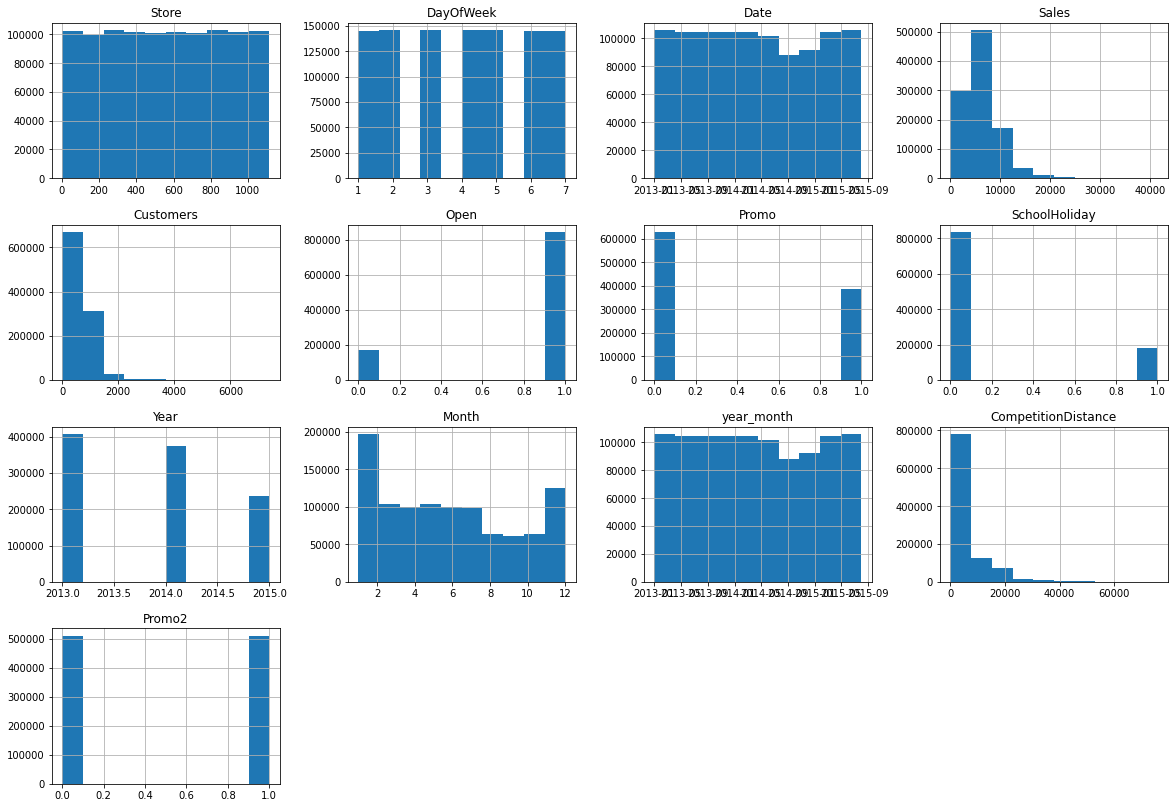

In [ ]:
past_data.hist(figsize=(20,14))
plt.show()

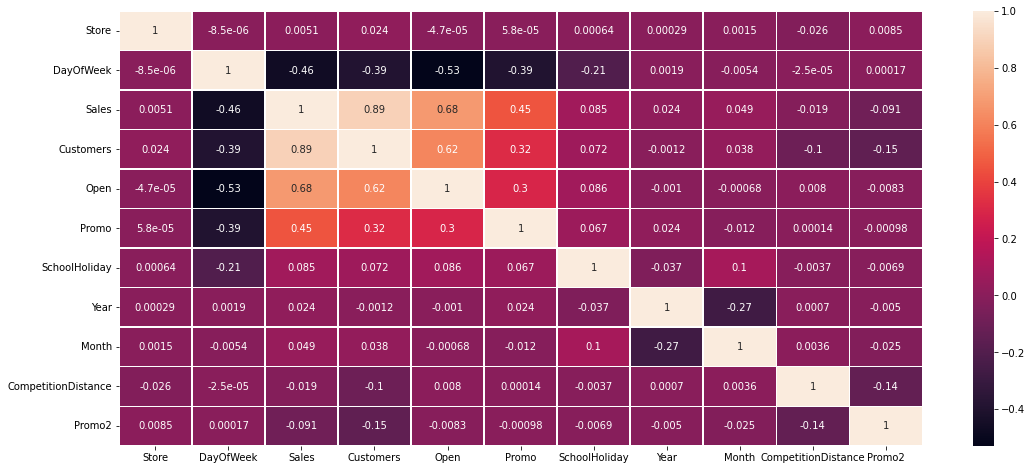

In [ ]:
correl = past_data.corr()
#Plotting the correlational heatmap using seaborn
plt.figure(figsize=(18,8))
sns.heatmap(correl, annot = True, linewidths = 0.5)


There is no correlation between the variables except diagonal element. So we can deduce that variables are independent.

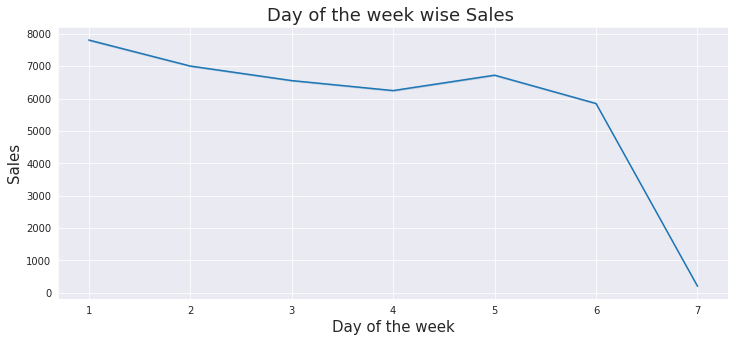

In [ ]:
#Day of the week wise sales
sns.set_style(style= 'darkgrid')
plt.figure(figsize=(12,5))
plt.title("Day of the week wise Sales ", fontsize = 18)
plt.ylabel("Sales",fontsize = 15)
plt.xlabel("Day of the week",fontsize = 15)
sns.lineplot(x='DayOfWeek', y='Sales', data = sales)

From the above line graph, we can observe that that the sales is at the peak on the first day of week and gradually decreases till the lowest which is at the last day of the week.



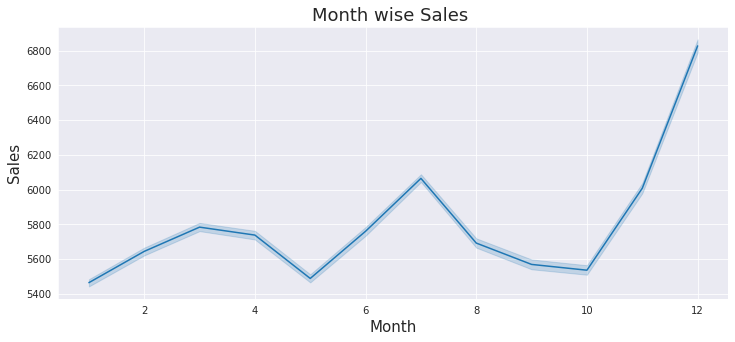

In [ ]:
#Month wise sales
sns.set_style(style= 'darkgrid')
plt.figure(figsize=(12,5))
plt.title("Month wise Sales ", fontsize = 18)
plt.ylabel("Sales",fontsize = 15)
plt.xlabel("Month",fontsize = 15)
sns.lineplot(x='Month', y='Sales', data = sales)

This particular line graph demonstrates the sales month wise and we can observe that december is the month of the highest sales and lowest in january.

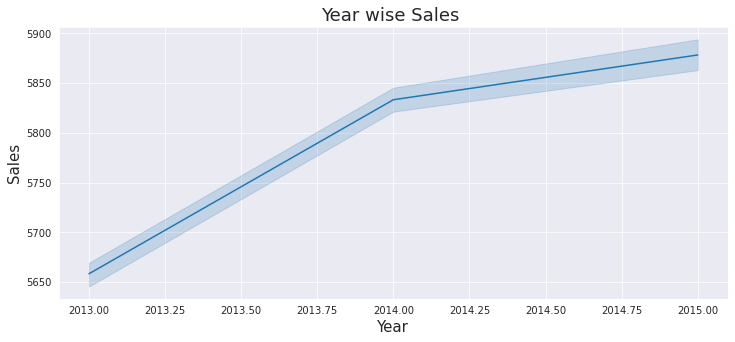

In [ ]:
#Year wise sales
sns.set_style(style= 'darkgrid')
plt.figure(figsize=(12,5))
plt.title("Year wise Sales ", fontsize = 18)
plt.ylabel("Sales",fontsize = 15)
plt.xlabel("Year",fontsize = 15)
sns.lineplot(x='Year', y='Sales', data = sales)

Similarly, this graph shows that the 2015 is the year when highest sales was recorded and 2013 was lowest.

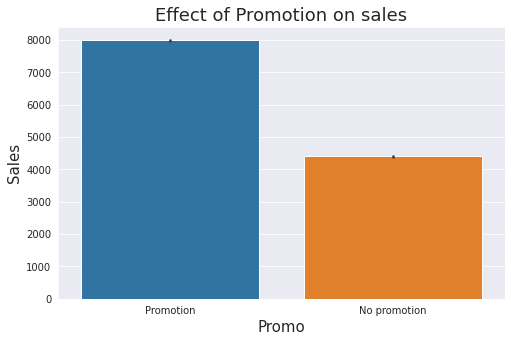

In [21]:
#Using seaborn to plot thye effect of promotions on sales 
sns.set_style(style= 'darkgrid')
plt.figure(figsize=(8,5))
plt.title("Effect of Promotion on sales", fontsize = 18)
plt.ylabel("Sales",fontsize = 15)
plt.xlabel("Promo",fontsize = 15)
sns.barplot(x='Promo', y='Sales', data = sales)

The bar represnts the promotion effects on sales and it can be deduced that the promotion is directly affecting the sales.

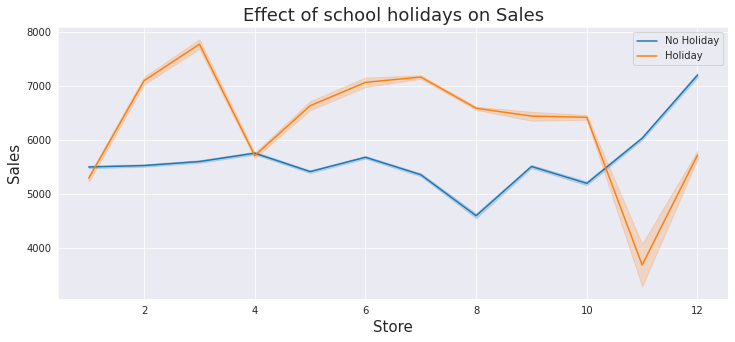

In [22]:
#Using seaborn to plot the trends of school holidays effect on sales 
sns.set_style(style= 'darkgrid')
plt.figure(figsize=(12,5))
plt.title("Effect of school holidays on Sales", fontsize = 18)
plt.ylabel("Sales", fontsize = 15)
plt.xlabel("Store", fontsize = 15)
sns.lineplot(x='Month', y='Sales',hue = 'SchoolHoliday', data = past_data)
plt.legend(['No Holiday', 'Holiday'])

This particular graph demonstrates the effect of school holidays on sales, And we can clearly observe that the school holidays are giving a boost to sales.

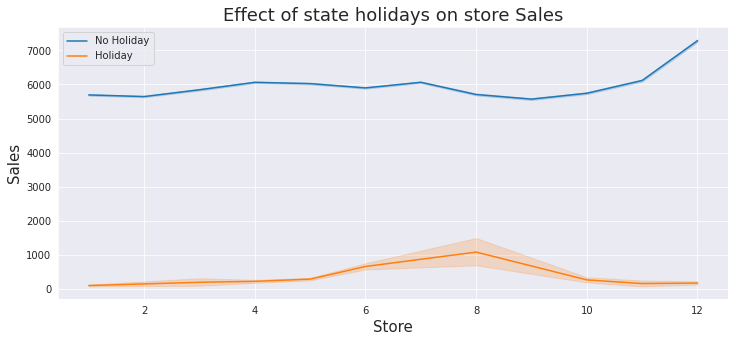

In [23]:
#Using seaborn to see the effect of state holidays on sales
sns.set_style(style= 'darkgrid')
plt.figure(figsize=(12,5))
plt.title("Effect of state holidays on store Sales", fontsize = 18)
plt.ylabel("Sales",fontsize = 15)
plt.xlabel("Store",fontsize = 15)
sns.lineplot(x='Month', y='Sales',hue = 'StateHoliday', data = past_data)
plt.legend(['No Holiday', 'Holiday'])

From the above graph we can deduce that on state holidays most of the stores were closed and thus the sale was not happening really throughout.

##Predictive analysis using Facebook Prophet 

But but but let's just understand first how the Facebook Prophet model work.
The facebook prophet additive regression model takes the form of this expression:
* In a nutshell the additive regression model explain the relationship between independent variable i.e X, and dependent variable i.e Y.
* What I mean from Independent variable is that if you change this independent variable X, the varibale Y will be predicted according to the change.
* And the series of this X function when added up, you lead towards the additive regression model and have a prediction for Y accordingly.
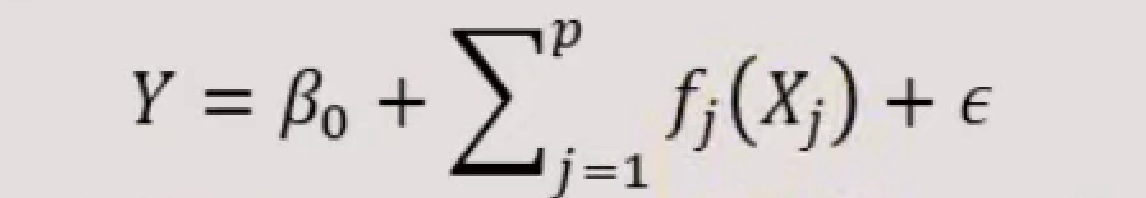

###Features of Facebook Prophet Model
* A piecewise linear or logistic growth curve trend. 
* Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.



###Feature engeneering

In [24]:
#Defining a feature for making a model and for determining the forecast of that model
#The feature will take store id, data and periods as a input to return the forecast and model
def sales_prediction0(store_id, past_data, periods):
  past_data = past_data[past_data['Store'] == store_id]
  past_data = past_data[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  past_data = past_data.sort_values(by = 'ds')

  model = Prophet()
  model.fit(past_data)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)

  return model,past_data, forecast

In [25]:
#Defining a feature for making a model and for determining the forecast of that model
#The feature will take store id, data and periods as a input to return the forecast and model after cosidering the closed day and all the holidays as well
def sales_prediction(store_id, past_data, holidays, periods):
  past_data = past_data[past_data['Store'] == store_id]
  past_data = past_data[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
  past_data = past_data.sort_values(by = 'ds')

  model = Prophet(holidays=holidays)
  model.fit(past_data)
  future = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future)

  return model,past_data, forecast

##Time to Predict, Let's gooo !!

In [27]:
#Predicting the data for nect 5 months of the year 2015
model0, df_origin0, df_prediction0 = sales_prediction0(10, past_data, 153)
#Plotting the predictied data
plot_plotly(model0, df_prediction0)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjriqer2_/1muw3ktn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjriqer2_/occxvyn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46417', 'data', 'file=/tmp/tmpjriqer2_/1muw3ktn.json', 'init=/tmp/tmpjriqer2_/occxvyn2.json', 'output', 'file=/tmp/tmpl5_1q7bq/prophet_model-20220915190100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


This particular graph shows the prediction for next 5 months of the year 2015, But it does not considers the holidays and the day stores were closed let's add them to the model, And let's see what we get.

In [ ]:
#Predicting the data for nect 5 months of the year 2015
model, df_origin, df_prediction = sales_prediction(10, past_data, school_state_holidays, 153)
#Plotting the predictied data
plot_plotly(model, df_prediction)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnltvezg4/ppkjgz7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnltvezg4/hpde68fe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38187', 'data', 'file=/tmp/tmpnltvezg4/ppkjgz7l.json', 'init=/tmp/tmpnltvezg4/hpde68fe.json', 'output', 'file=/tmp/tmpfch_v3l1/prophet_model-20220914133149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Woah, Now it's better, the holidays and closed days were added to the model.
Predictions are positive and in future it will tend to rise at a postive rate.

In [ ]:
#Creating a new dataframe for the forecatsed data and saving it to csv
forecasted_data = df_prediction[['ds', 'yhat']].rename(columns = {'ds': 'Date', 'yhat': 'Sales'})
forecasted_data = forecasted_data[942:]
forecasted_data.to_csv('forecasted_data.csv', index=False)
forecasted_data

,Date,Sales
942,2015-08-01,5031.889192
943,2015-08-02,201.005313
944,2015-08-03,6520.449656
945,2015-08-04,5838.303808
946,2015-08-05,5404.973944
...,...,...
1090,2015-12-27,544.671441
1091,2015-12-28,6820.708232
1092,2015-12-29,6099.422560
1093,2015-12-30,5631.698676


##Conclusion


* There is no correlation between the variables except diagonal element. So we can deduce that variables are independent.

* The sales were at the peak on the first day of week and gradually decreases till the lowest which is at the last day of the week.

* December is the month of the highest sales and lowest in janurary.

* The year 2015 is  when highest sales was recorded and 2013 was lowest.
	
* The promotion is directly affecting the sales.

* The school holidays are giving a boost to sales.

* On state holidays most of the stores were closed and thus the saleS was not happening really throughout.

* And at last when the holidays and closed days were added to the model.
Predictions are positive and in future it will tend to rise at a postive rate.

Refrences: 
1. https://research.facebook.com/blog/2017/02/prophet-forecasting-at-scale/#:~:text=At%20its%20core%2C%20the%20Prophet,component%20modeled%20using%20Fourier%20series.

2. https://facebook.github.io/prophet/docs/quick_start.html

Thanks everone for staying up till here, Keep analysing. See you all in the next project. <3